# Домашняя работа 2. Линейная регрессия. Работа с синтетическими данными

Импортируем библиотеки

In [1]:
import pandas as pd
from google.colab import files 

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns; 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

Класс Линейной регрессии без регуляризации

In [64]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #Прямое распространение
    def forward(self, X):
        return np.dot(X, self.weights)
    
    #Рассчет потерь MSE
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #Рассчет градиента 
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #Обновление весов с учетом шага и градиента
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #Инициализация весов
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #Прогнозирование целевой переменной с текущей моделью
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #Оценка работы модели
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
    #Обучение модели
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]
    #Загрузка батча
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #Добавление колонки смещения
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #Построение графика потерь для проверки работы алгоритма
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #Возвращение текущих весов w1, w2, ..., wn и b
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

Класс линейной регрессии с регуляризацией Тихонова (L2)

In [122]:
class RidgeRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l2_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l2_penalty = l2_penalty
        
    #Подсчет ошибок
    def loss(self,yhat, y):   
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l2_term

    #Обновление весов с учетом "штрафа" за большие размеры
    def update(self):    
        l2_term = self.l2_penalty*np.mean(self.weights[1:])
        return self.weights - self.lr*(self.grad + l2_term)  

Класс линейной регрессии с L1 регуляризацией 

In [129]:
class LassoRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
    
    #Рассчет среднеквадратической ошибки
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term
                  
    #Обновление весов с учетом шага, градиента и "штрафа" за размер весов
    def update(self):    
        return self.weights - self.lr*(self.grad + np.sign(self.weights)*self.l1_penalty)

Функция для визуализации весов

In [128]:
def vis_weigths(weights):
    numbers = np.arange(0,len(weights))
    tick_labels = ['w'+str(num) for num in numbers]
    cc=['']*len(numbers)
    for n,val in enumerate(weights):
        if val<0:
            cc[n]='red'
        elif val>=0:
            cc[n]='blue'

    plt.bar(x = numbers, height = weights, color = cc)
    plt.xticks(np.arange(0,len(weights)),tick_labels );

Функция для визуализации потерь

In [127]:
def plot_cost(cost):
    plt.plot(cost, 'o-', linewidth = 4, markersize = 15); 
    plt.grid()
    plt.xlabel("Эпоха",fontsize=35)
    plt.ylabel("Функция Потерь",fontsize=35)
    plt.xticks(FontSize = 25)

    plt.yticks(FontSize = 25);  

Функция для разбиения данных на тренировочную и тестовую выборки

In [48]:
def train_test_split(x,y, train_size=None, test_size=None, random_state=42, shuffle=True,):
    if random_state: np.random.seed(random_state)
    
    size = y.shape[0]
    idxs = np.arange(size)
    if shuffle: np.random.shuffle(idxs)
    
    if test_size and train_size is None:
        if (test_size<= 1):  train_size = 1 - test_size
        else:  train_size = size - test_size
        test_size = None    
        
    if train_size is None or train_size > size: train_size = size
        
    if (train_size<= 1): train_size *= size
        
    if test_size is not None: 
        if test_size<= 1: test_size *= size    
        if test_size>size: test_size = size-train_size
    else: test_size = 0

    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    x_val,   y_val   = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]
    
    if test_size > 0:
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        return x_train, y_train.squeeze(), x_val, y_val.squeeze(), x_test, y_test.squeeze() 
    return x_train, y_train.squeeze(), x_val, y_val.squeeze()


x_train, y_train, x_val, y_val, x_test, y_test = train_test_split(x, y, train_size = 0.5, test_size=0.3, )    
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape,  x_test.shape, y_test.shape )

    
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )

(125, 1) (125,) (50, 1) (50,) (75, 1) (75,)
(175, 1) (175,) (75, 1) (75,)


Для реализации полиномиальной регрессии - функция, создающая полином из входных данных

In [49]:
def to_polynom(x, order = 1, add_bias = False):
    order_range = range( 0 if add_bias else 1, order+1,1)
    x = np.atleast_1d(x)[:]    
    out = np.array([])
    for i in order_range:
        out = np.append(out, np.power(x,i))
    return out.reshape(-1, x.size).T

Функции генерации, зашумления и форматирования данных

In [65]:
def true_fun(x, a=np.pi, b = 0, f=np.sin):
    x = np.atleast_1d(x)[:]
    a = np.atleast_1d(a)
    
    if f is None: f = lambda x:x # line
    x = np.sum([ai*np.power(x, i+1) for i,ai in enumerate(a)],axis=0)

    return f(x+ b)

def noises(shape , noise_power):
    return np.random.randn(*shape) *noise_power

def dataset(a, b, f = None,  N = 250, x_max =1, noise_power = 0, random_x = True,  seed = 42):
    np.random.seed(seed)
    
    if random_x:
        x = np.sort(np.random.rand(N))*x_max    
    else:
        x = np.linspace(0,x_max,N)
    
    y_true = np.array([])
    
    for f_ in np.append([], f):
        y_true=np.append(y_true, true_fun(x, a, b, f_))
    
    y_true = y_true.reshape(-1,N).T
    y = y_true + noises(y_true.shape , noise_power)

    return y, y_true, np.atleast_2d(x).T

Функция для визуализации данных

In [51]:
def vis_data(y, y_true,x, title):
    fig  = plt.figure(figsize=(9,6))
    plt.scatter(x[:,0], y, edgecolor='b', label="Зашумленные Данные",s=196, alpha = 0.6)
    plt.scatter(x[:,0], y_true,label="Реальные Данные", s=81,c='g', alpha = 0.8)
    plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35)
    plt.legend(fontsize=25)
    plt.title(title, fontsize=25 )
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);
    plt.tight_layout()

Функция для визуализации результатов линейной регрессии

In [52]:
def plot_model_class(x_train, y_train, x_test, x, y, model):
    plt.plot(x_train[:,0], model.predict(x_train),
            '.', label='Предсказание на x_train',
            markersize = 15)
    plt.plot(x_test[:,0], model.predict(x_test),
            'o', label='Предсказание на x_test',
            markersize = 15, alpha =0.8)
    plt.plot(x_train[:,0], y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label="Истинные Значения", linewidth=4,c='g')
    plt.legend(fontsize=20); plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35);
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);

## Датасет 1. Полиномиальная зависимость

Генерируем датасет

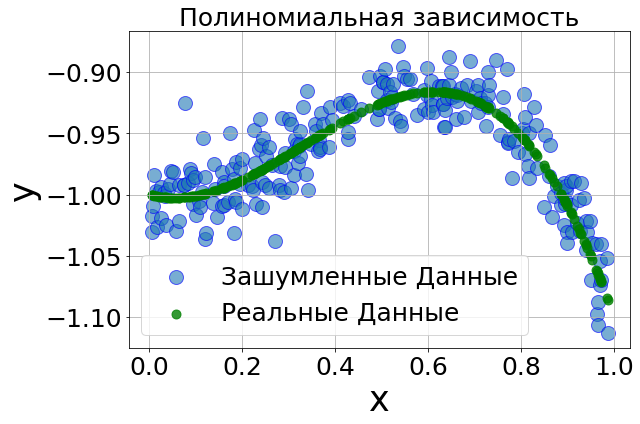

In [270]:
noise_power = 0.02

y, y_true, x = dataset(a = [-0.1, 1, -1], b = -1,
                       f = None,  N = 250,
                       x_max = 1, 
                       noise_power = noise_power,
                       seed = 42)
vis_data(y, y_true,x, 'Полиномиальная зависимость')

### Полином 5 степени

In [320]:
x_ = to_polynom(x, order = 5) 
x_train, y_train,  x_test, y_test = train_test_split(x_, y,  test_size=0.3)

In [321]:
regr_poly = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=10,
                        n_batches=None)

In [322]:
regr_poly.fit(x_train, y_train)

Test Score = 0.72, Train Score = 0.81


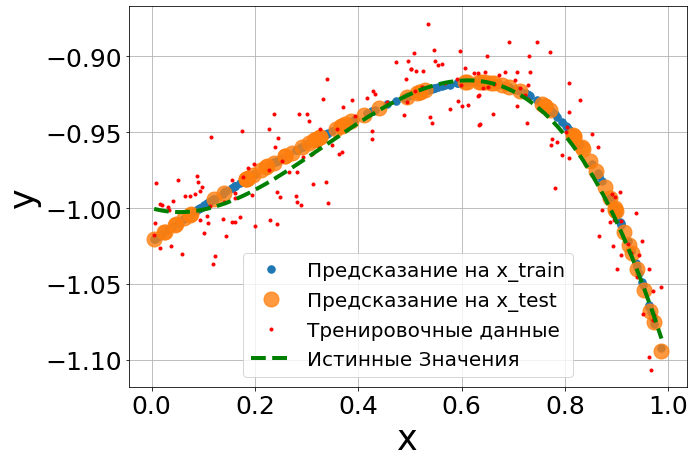

In [323]:
fig  = plt.figure(figsize=(10,7))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly)
print(f'Test Score = {regr_poly.score(x_test, y_test):.2f}, Train Score = {regr_poly.score(x_train, y_train):.2f}')

### Полином 3 степени

In [275]:
x_ = to_polynom(x, order = 3) 
x_train, y_train,  x_test, y_test = train_test_split(x_, y,  test_size=0.3)

In [276]:
regr_poly = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=10,
                        n_batches=None)

In [277]:
regr_poly.fit(x_train, y_train)

Test Score = 0.59, Train Score = 0.71


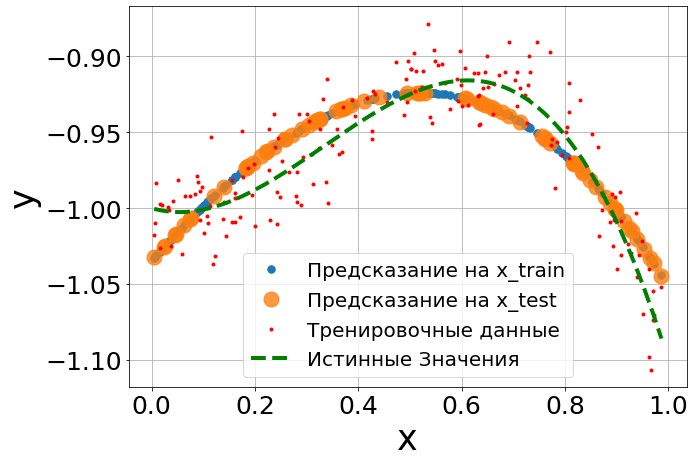

In [278]:
fig  = plt.figure(figsize=(10,7))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly)
print(f'Test Score = {regr_poly.score(x_test, y_test):.2f}, Train Score = {regr_poly.score(x_train, y_train):.2f}')

### Полином 8 степени

In [299]:
x_ = to_polynom(x, order = 8) 
x_train, y_train,  x_test, y_test = train_test_split(x_, y,  test_size=0.3)

In [300]:
regr_poly = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=10,
                        n_batches=None)

In [301]:
regr_poly.fit(x_train, y_train)

Test Score = 0.73, Train Score = 0.81


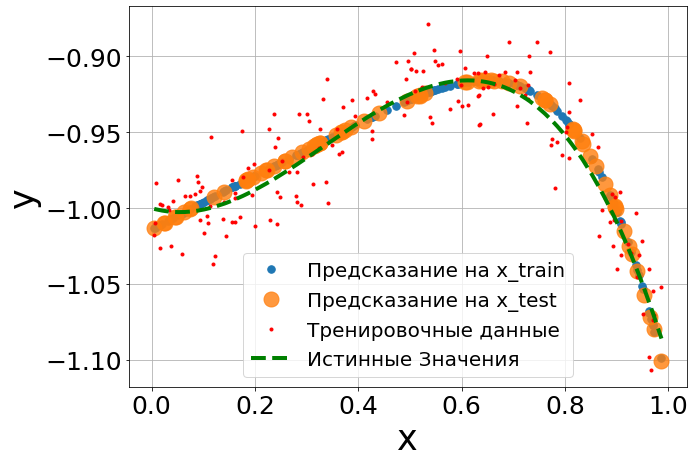

In [302]:
fig  = plt.figure(figsize=(10,7))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly)
print(f'Test Score = {regr_poly.score(x_test, y_test):.2f}, Train Score = {regr_poly.score(x_train, y_train):.2f}')

### Полином 10 степени

In [314]:
x_ = to_polynom(x, order = 30) 
x_train, y_train,  x_test, y_test = train_test_split(x_, y,  test_size=0.3)

In [315]:
regr_poly = LinearRegression(learning_rate=0.1,
                        epochs=1000,batch_size=10,
                        n_batches=None)

In [316]:
regr_poly.fit(x_train, y_train)

Test Score = 0.72, Train Score = 0.81


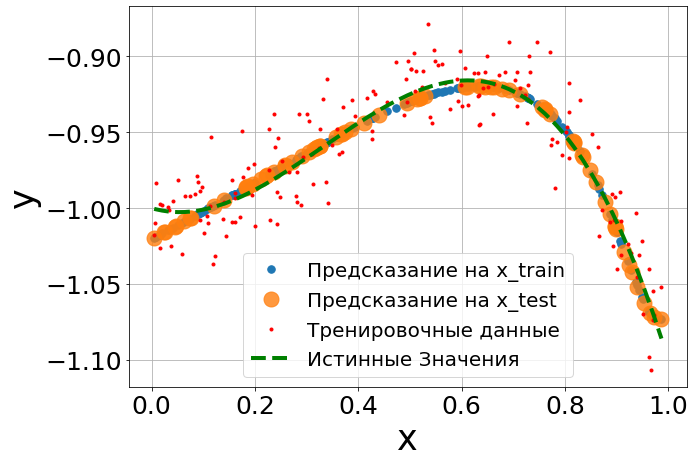

In [317]:
fig  = plt.figure(figsize=(10,7))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly)
print(f'Test Score = {regr_poly.score(x_test, y_test):.2f}, Train Score = {regr_poly.score(x_train, y_train):.2f}')

**Степень полинома меньше 5 дает недостаточно точные предсказания, в то время как повышение степени до 8 и даже 30 улучшает результат только незначительно**

### L2 регуляризация

In [324]:
regr_l2 = RidgeRegression(learning_rate=0.25,
                       epochs=300, batch_size=10,
                       l2_penalty = 0.001)
regr_l2.fit(x_train, y_train)

print(f'Test Score = {regr_l2.score(x_test, y_test):.2f}, Train Score = {regr_l2.score(x_train, y_train):.2f}')

Test Score = 0.59, Train Score = 0.75


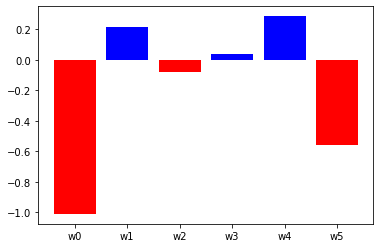

In [325]:
w, b = regr_l2.get_w_and_b()
vis_weigths(np.hstack([b,w]))

### L1 регуляризация

In [326]:
regr_l1 = LassoRegression(learning_rate=0.1,
                       epochs=300,batch_size=10,
                       l1_penalty = 0.001)
regr_l1.fit(x_train, y_train)

print(f'Test Score = {regr_l1.score(x_test, y_test):.2f}, Train Score = {regr_l1.score(x_train, y_train):.2f}')

Test Score = 0.69, Train Score = 0.78


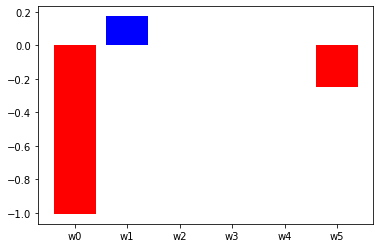

In [327]:
w, b = regr_l1.get_w_and_b()
vis_weigths(np.hstack([b,w]))

L1 регуляризация не улучшила результат, в то время как регуляризация Тихонова оказалась вредна для модели. 

## Экспоненциальная зависимость

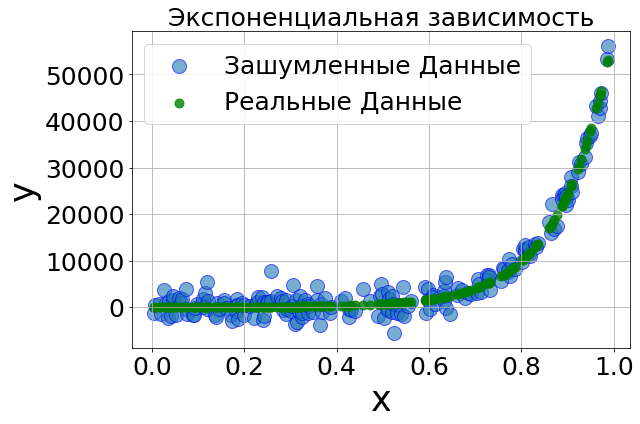

In [192]:
noise_power = 2000

y, y_true, x = dataset(a = 9, b = 2,
                       f = np.exp,  N = 200,
                       x_max = 1, 
                       noise_power = noise_power,
                       seed = 42)
vis_data(y, y_true, x, 'Экспоненциальная зависимость')

### Полином 3 степени

In [193]:
x_ = to_polynom(x, order = 3) 
x_train, y_train,  x_test, y_test = train_test_split(x_, y,  test_size=0.3)

In [194]:
regr_poly = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=10,
                        n_batches=None)
regr_poly.fit(x_train, y_train)

Test Score = 0.90, Train Score = 0.88


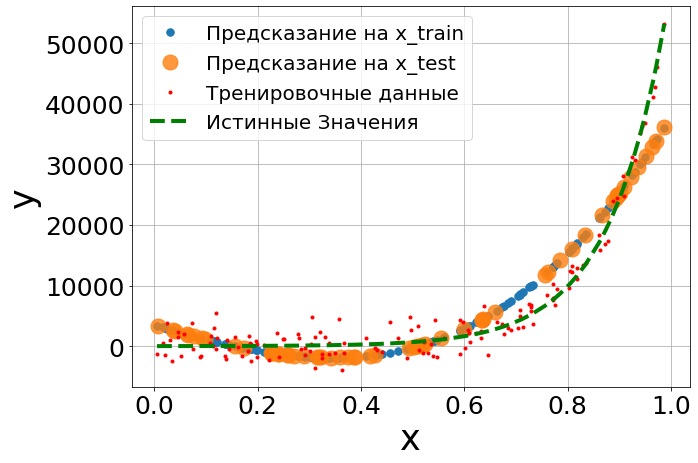

In [195]:
fig  = plt.figure(figsize=(10,7))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly)
print(f'Test Score = {regr_poly.score(x_test, y_test):.2f}, Train Score = {regr_poly.score(x_train, y_train):.2f}')

### Полином 5 степени

In [196]:
x_ = to_polynom(x, order = 5) 
x_train, y_train,  x_test, y_test = train_test_split(x_, y,  test_size=0.3)

In [197]:
regr_poly = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=10,
                        n_batches=None)
regr_poly.fit(x_train, y_train)

Test Score = 0.95, Train Score = 0.94


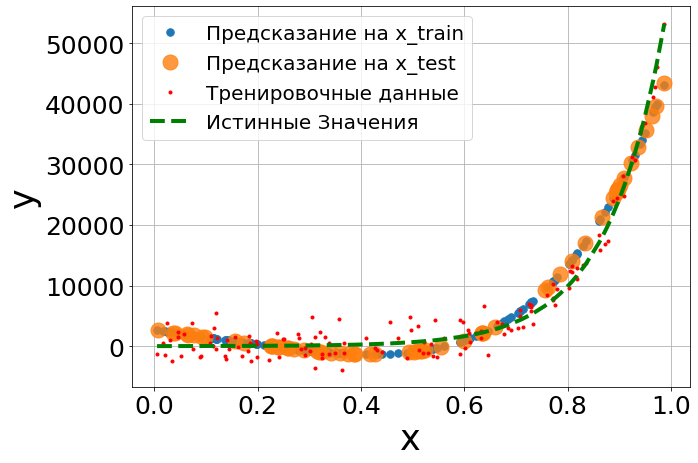

In [198]:
fig  = plt.figure(figsize=(10,7))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly)
print(f'Test Score = {regr_poly.score(x_test, y_test):.2f}, Train Score = {regr_poly.score(x_train, y_train):.2f}')

### Полином 10 степени

In [202]:
x_ = to_polynom(x, order = 10) 
x_train, y_train,  x_test, y_test = train_test_split(x_, y,  test_size=0.3)

In [203]:
regr_poly = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=10,
                        n_batches=None)
regr_poly.fit(x_train, y_train)

Test Score = 0.98, Train Score = 0.97


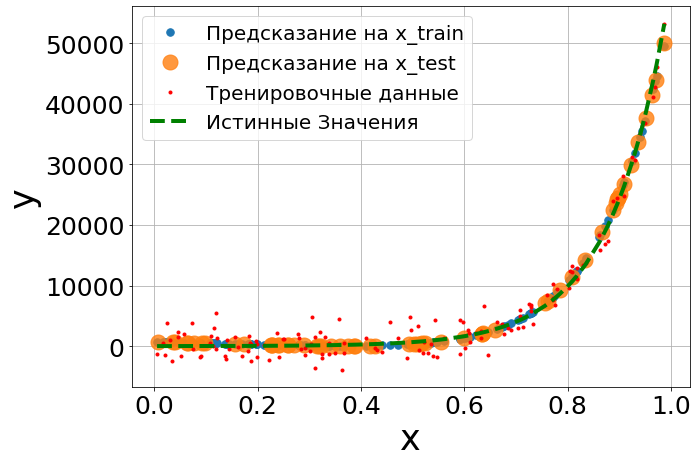

In [204]:
fig  = plt.figure(figsize=(10,7))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly)
print(f'Test Score = {regr_poly.score(x_test, y_test):.2f}, Train Score = {regr_poly.score(x_train, y_train):.2f}')

Экспоненциальная зависимость очень хорошо описывается полиномами с большей степенью.

### L1 регуляризация

In [205]:
regr_l1 = LassoRegression(learning_rate=0.1,
                       epochs=300,batch_size=10,
                       l1_penalty = 0.001)
regr_l1.fit(x_train, y_train)

print(f'Test Score = {regr_l1.score(x_test, y_test):.2f}, Train Score = {regr_l1.score(x_train, y_train):.2f}')

Test Score = 0.98, Train Score = 0.97


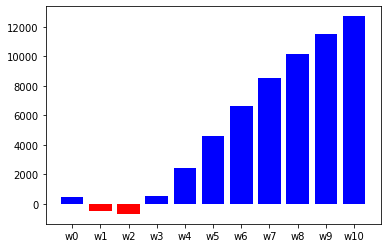

In [206]:
w, b = regr_l1.get_w_and_b()
vis_weigths(np.hstack([b,w]))

### L2 регуляризация

In [207]:
regr_l2 = RidgeRegression(learning_rate=0.25,
                       epochs=300, batch_size=10,
                       l2_penalty = 0.001)
regr_l2.fit(x_train, y_train)

print(f'Test Score = {regr_l2.score(x_test, y_test):.2f}, Train Score = {regr_l2.score(x_train, y_train):.2f}')

Test Score = 0.97, Train Score = 0.97


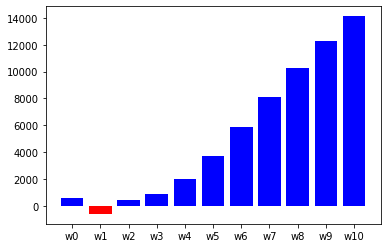

In [208]:
w, b = regr_l2.get_w_and_b()
vis_weigths(np.hstack([b,w]))

Оба типа регуляризации дают почти одинаковые результаты

## Гармоническая зависимость

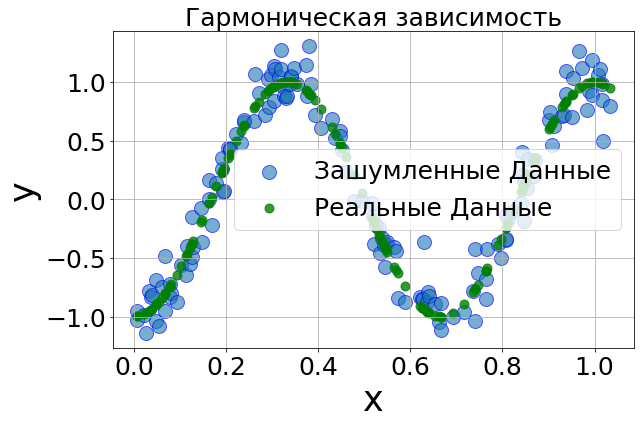

In [223]:
noise_power = 0.15

y, y_true, x = dataset(a = 3*np.pi, b = np.pi,
                       f = np.cos,  N = 150,
                       x_max = np.pi/3, 
                       noise_power = noise_power,
                       seed = 42)
vis_data(y, y_true,x, 'Гармоническая зависимость')


### Полином 3 степени

In [224]:
x_ = to_polynom(x, order = 3) 
x_train, y_train,  x_test, y_test = train_test_split(x_, y,  test_size=0.3)

In [225]:
regr_poly = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=10,
                        n_batches=None)
regr_poly.fit(x_train, y_train)

Test Score = 0.04, Train Score = 0.12


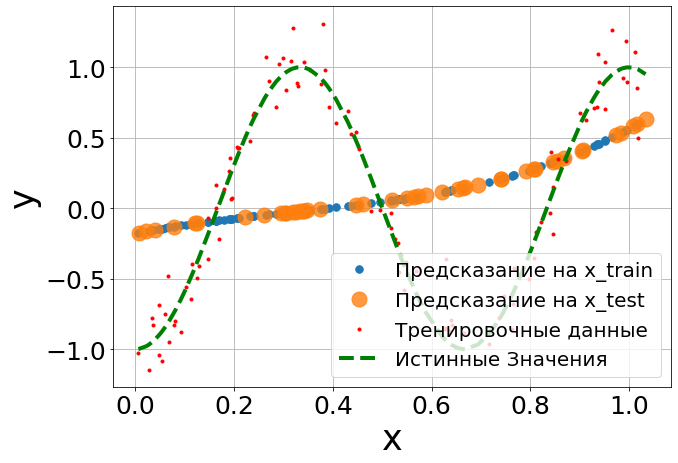

In [226]:
fig  = plt.figure(figsize=(10,7))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly)
print(f'Test Score = {regr_poly.score(x_test, y_test):.2f}, Train Score = {regr_poly.score(x_train, y_train):.2f}')

### Полином 5 степени

In [227]:
x_ = to_polynom(x, order = 5) 
x_train, y_train,  x_test, y_test = train_test_split(x_, y,  test_size=0.3)

In [228]:
regr_poly = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=10,
                        n_batches=None)
regr_poly.fit(x_train, y_train)

Test Score = 0.21, Train Score = 0.25


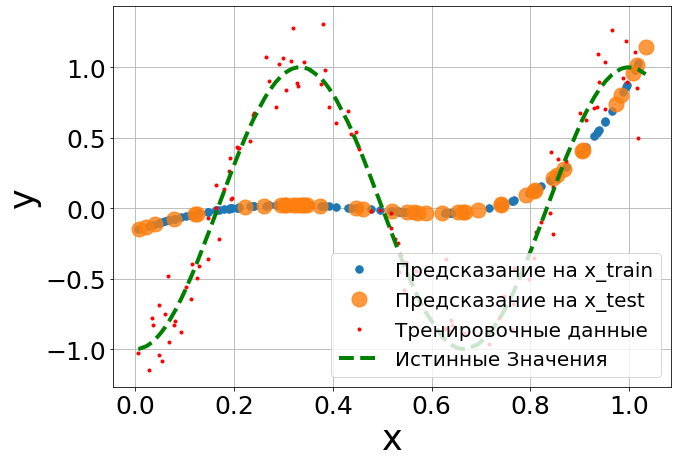

In [229]:
fig  = plt.figure(figsize=(10,7))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly)
print(f'Test Score = {regr_poly.score(x_test, y_test):.2f}, Train Score = {regr_poly.score(x_train, y_train):.2f}')

### Полином 10 степени

In [262]:
x_ = to_polynom(x, order = 10) 
x_train, y_train,  x_test, y_test = train_test_split(x_, y,  test_size=0.3)

In [263]:
regr_poly = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=10,
                        n_batches=None)
regr_poly.fit(x_train, y_train)

Test Score = 0.25, Train Score = 0.33


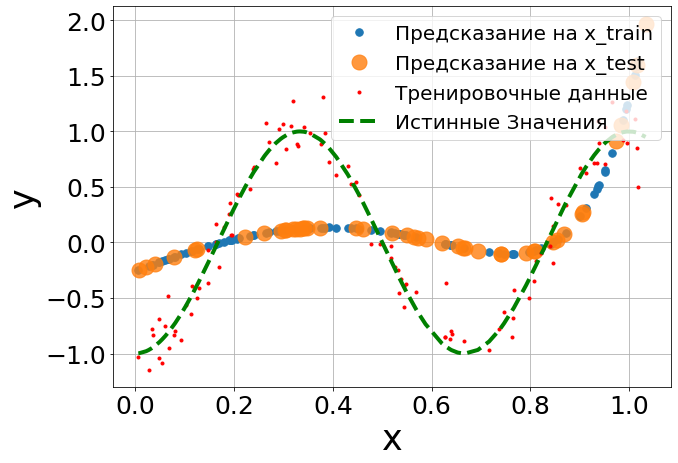

In [264]:
fig  = plt.figure(figsize=(10,7))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly)
print(f'Test Score = {regr_poly.score(x_test, y_test):.2f}, Train Score = {regr_poly.score(x_train, y_train):.2f}')

### Полином 30 степени + 3600 эпох

In [245]:
x_ = to_polynom(x, order = 30) 
x_train, y_train,  x_test, y_test = train_test_split(x_, y,  test_size=0.3)

In [258]:
regr_poly = LinearRegression(learning_rate=0.1,
                        epochs=3600,batch_size=10,
                        n_batches=None)
regr_poly.fit(x_train, y_train)

Test Score = 0.85, Train Score = 0.87


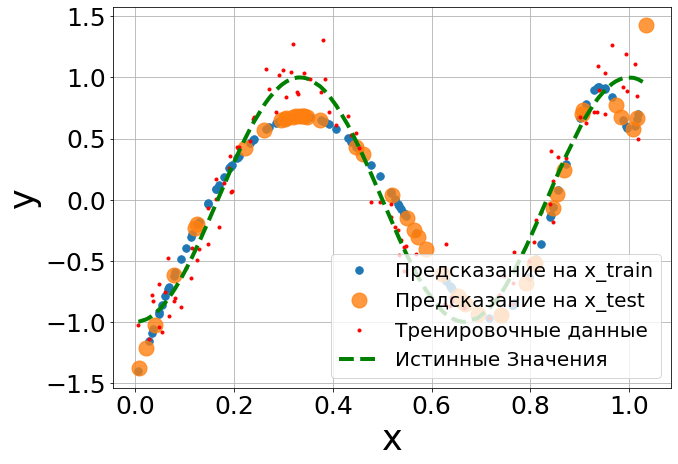

In [259]:
fig  = plt.figure(figsize=(10,7))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly)
print(f'Test Score = {regr_poly.score(x_test, y_test):.2f}, Train Score = {regr_poly.score(x_train, y_train):.2f}')

При фиксированном количестве эпох повышение степени улучшает результаты модели. Наилучшего результата удалось добиться, одновременно увеличив степень и количество эпох. Однако качество предсказаний ограничено, с дальнейшим повышением количества эпох потери на тестовых данных повышаются.

### L1 регуляризация

In [266]:
regr_l1 = LassoRegression(learning_rate=0.1,
                       epochs=300,batch_size=10,
                       l1_penalty = 0.001)
regr_l1.fit(x_train, y_train)

print(f'Test Score = {regr_l1.score(x_test, y_test):.2f}, Train Score = {regr_l1.score(x_train, y_train):.2f}')

Test Score = 0.37, Train Score = 0.44


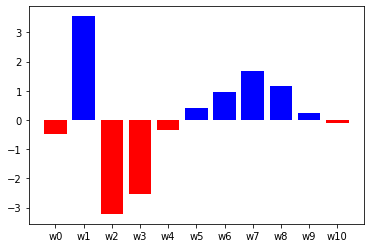

In [267]:
w, b = regr_l1.get_w_and_b()
vis_weigths(np.hstack([b,w]))

### L2 регуляризация

In [268]:
regr_l2 = RidgeRegression(learning_rate=0.25,
                       epochs=300, batch_size=10,
                       l2_penalty = 0.001)
regr_l2.fit(x_train, y_train)

print(f'Test Score = {regr_l2.score(x_test, y_test):.2f}, Train Score = {regr_l2.score(x_train, y_train):.2f}')

Test Score = 0.55, Train Score = 0.60


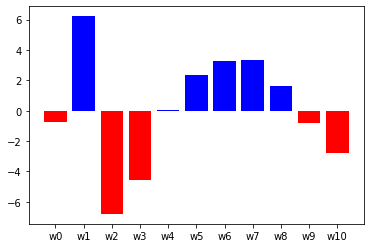

In [269]:
w, b = regr_l2.get_w_and_b()
vis_weigths(np.hstack([b,w]))

L2 регуляризация показала лучшие результаты в сравнении с L1 регуляризацией.